In [16]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Binarization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, morphology, measure, segmentation
from scipy import ndimage

def binarization_segmentation(image_path):
    # Load the image
    img = io.imread(image_path)

    # Convert to grayscale
    gray = np.mean(img, axis=2)

    # Apply a smoothing filter
    smooth = filters.gaussian(gray, sigma=1)

    # Apply Otsu thresholding
    # separate the image to foreground and other things
    thresh = filters.threshold_otsu(smooth)
    binary = smooth > thresh

    # Fill holes in binary image
    # filled = ndimage.binary_fill_holes(binary)

    # Apply watershed algorithm
    distance = ndimage.distance_transform_edt(binary)
    local_max = morphology.local_maxima(distance, indices=False, footprint=np.ones((3,3)))
    markers = measure.label(local_max)
    labels = segmentation.watershed(-distance, markers, mask=binary)

    # Extract shape features of each region
    props = measure.regionprops(labels)

    # Assign a color to each region based on the color of its pixels
    colors = img.copy()
    for prop in props:
        color = np.array([0, 0, 255]) # set color to blue
        colors[labels == prop.label] = color

    # Display the colored regions
    fig, ax = plt.subplots()
    ax.imshow(colors)
    plt.show()

In [ ]:
binarization_segmentation('image.jpg')

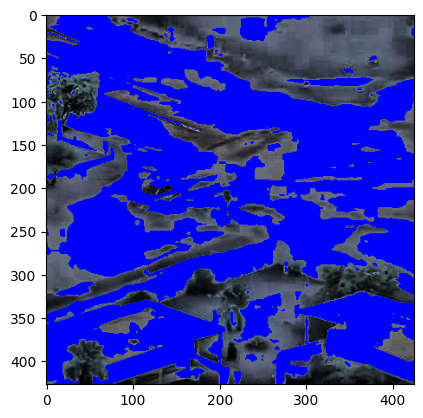

In [ ]:
binarization_segmentation('/content/drive/MyDrive/SI_flood_dataset/dataset/SI_flood_dataset_split/train_eq/flooded/10.jpg')

Clustering - kmeans : 3 - 2 clusters

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import cv2
import matplotlib.pyplot as plt

def k_means(image_path, n_clusters):
    # Load the image
    image = io.imread(image_path)

    # Flatten the image into a 2D array of pixels
    pixel_values = image.reshape((-1, 3))

    # Perform K-Means clustering with k=3 (you can adjust this value)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pixel_values)

    # Reshape the cluster labels into the original image shape
    segmented_image = kmeans.labels_.reshape(image.shape[:2])

    # print number of bands of the image
    print('The number of bands of the image is: ', image.shape[2])

    # print name of labels 
    print('The name of labels is: ', np.unique(kmeans.labels_))

    # Display the segmented image
    plt.imshow(segmented_image)
    plt.show()

    # use the segmented_image as a mask to extract the flooded area from the original image
    # make the flooded area to be blue color and leave the rest as it is 

    flooded_img = image.copy()

    flooded_img[segmented_image == 1] = (255,0,0)

    plt.imshow(flooded_img)
    plt.show()

    # cv2.imwrite('flooded_img.jpg', flooded_img)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The number of bands of the image is:  3
The name of labels is:  [0 1 2]


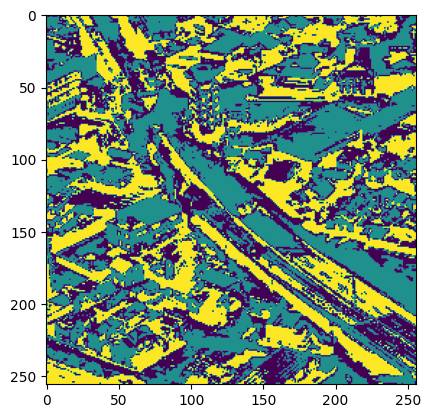

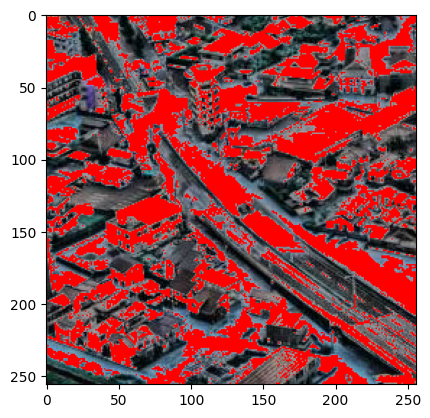

In [ ]:
k_means('/content/drive/MyDrive/SI_flood_dataset/dataset/SI_flood_dataset_split/train_resized_eq/flooded/14.jpg', 3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The number of bands of the image is:  3
The name of labels is:  [0 1]


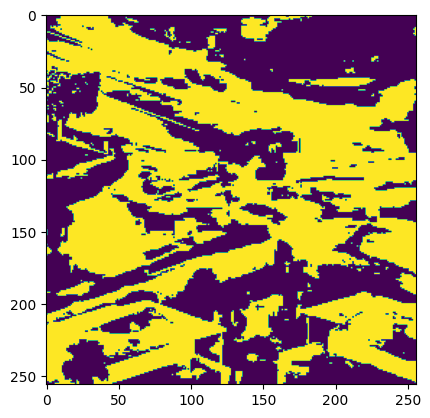

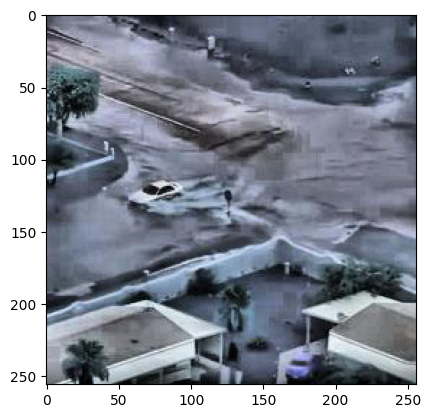

In [ ]:
k_means('/content/drive/MyDrive/SI_flood_dataset/dataset/SI_flood_dataset_split/train_resized_eq/flooded/10.jpg', 2)

use a thresholding technique that separates the image into foreground (water and bodies) and background (shadow) regions before applying K-Means clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The name of labels is:  [0 0 0 ... 0 0 0]


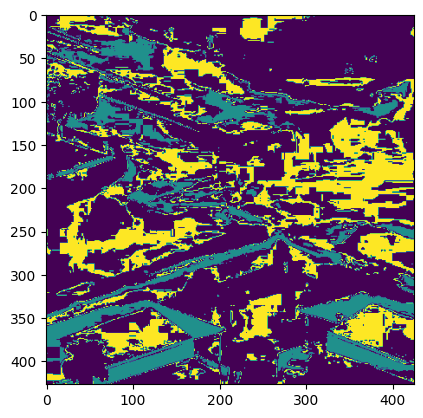

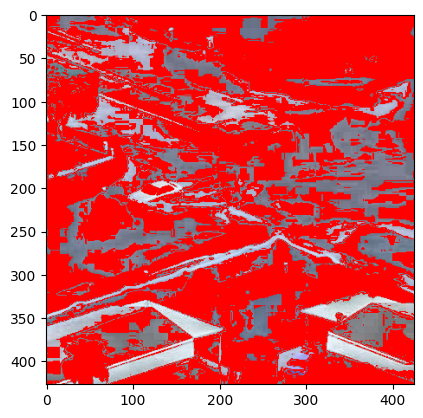

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the image
image = io.imread('/content/drive/MyDrive/SI_flood_dataset/dataset/SI_flood_dataset_split/train_eq/flooded/10.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Otsu's thresholding to segment the image into foreground and background
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Flatten the image into a 2D array of pixels
pixel_values = image.reshape((-1, 3))

# Create a mask for the foreground pixels
mask = np.zeros(thresh.shape[:2], dtype=np.uint8)
mask[thresh == 255] = 1

# Create a flattened version of the mask
flat_mask = mask.reshape(-1)

# Set the pixel values of the background regions to the same value as the water
pixel_values[flat_mask == 0] = pixel_values[flat_mask == 1].mean(axis=0)

# Perform K-Means clustering with k=3 (you can adjust this value)
kmeans = KMeans(n_clusters=3, random_state=0).fit(pixel_values)

# Reshape the cluster labels into the original image shape
segmented_image = kmeans.labels_.reshape(image.shape[:2])

print('The name of labels is: ', kmeans.labels_)

# Display the segmented image
plt.imshow(segmented_image)
plt.show()

# # Convert the segmented image to a binary mask
# mask = np.uint8(segmented_image == 1)

# # Find the contours of the holes in the mask
# contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Calculate the mean size of the contours
# total_size = 0
# for contour in contours:
#     total_size += cv2.contourArea(contour)
# inpaint_radius = int(total_size / len(contours))

# # Convert the segmented image to an 8-bit single-channel image
# segmented_image = cv2.convertScaleAbs(segmented_image)

# # Set the inpainting radius based on the size of the holes
# inpaint_image = cv2.inpaint(segmented_image, mask, inpaintRadius=inpaint_radius, flags=cv2.INPAINT_TELEA)

# plt.imshow(inpaint_image)
# plt.show()

flooded_img = image.copy()

flooded_img[segmented_image == 0] = (255,0,0)

plt.imshow(flooded_img)
plt.show()

region growing: image segmentation algorithm that groups together neighboring pixels with similar properties(color and texture) into regions.

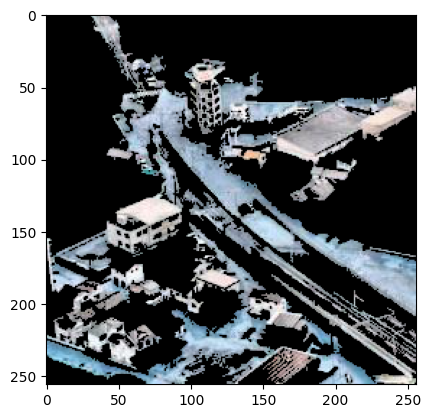

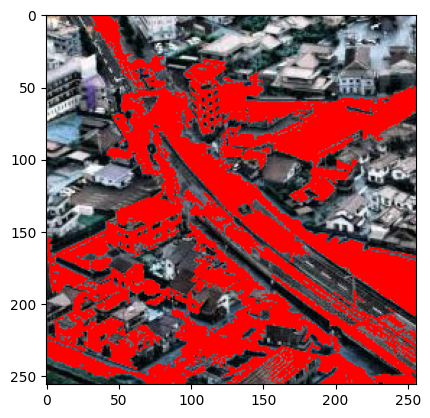

[[[179 142 116]
  [162 125  99]
  [192 152 127]
  ...
  [168 182 208]
  [188 202 228]
  [196 211 234]]

 [[184 150 125]
  [159 124 102]
  [179 144 122]
  ...
  [194 209 232]
  [211 226 249]
  [209 221 245]]

 [[201 176 154]
  [208 181 160]
  [203 176 155]
  ...
  [200 215 238]
  [205 220 241]
  [207 219 241]]

 ...

 [[  7  28  23]
  [ 17  38  33]
  [ 21  42  37]
  ...
  [255   0   0]
  [255   0   0]
  [255   0   0]]

 [[ 17  22  25]
  [ 18  26  28]
  [ 19  27  29]
  ...
  [255   0   0]
  [255   0   0]
  [255   0   0]]

 [[  5   3   8]
  [ 19  18  23]
  [ 28  29  33]
  ...
  [255   0   0]
  [255   0   0]
  [101 112  96]]]


In [ ]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.pyplot as plt
from skimage import io

# Load the image
# image = cv2.imread('image.jpg')
image = io.imread('/content/drive/MyDrive/SI_flood_dataset/dataset/SI_flood_dataset_split/train_resized_eq/flooded/14.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Otsu's thresholding to segment the image into foreground and background
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Perform connected component labeling to segment the image into regions
label_image = label(thresh)

# Find the properties of each region
regions = regionprops(label_image)

# Find the region with the largest area (assuming it's the flooded region)
flooded_region = max(regions, key=lambda x: x.area)

# Create a binary mask for the flooded region
mask = np.zeros_like(gray)
mask[label_image == flooded_region.label] = 255

# Apply the mask to the original image to obtain the segmented image
segmented_image = cv2.bitwise_and(image, image, mask=mask)

# cv2.imwrite('segmented_image_regionGrowing.jpg', segmented_image)

# Display the segmented image
plt.imshow(segmented_image)
plt.show()

flood_image = image.copy()
flood_image[mask == 255] = (255,0,0)

# cv2.imwrite('flooded_img_regionGrowing.jpg', flood_image)

# Display the flooded image
plt.imshow(flood_image)
plt.show()

print(flood_image)

In [17]:
import numpy as np
import random

class Cluster:
    def __init__(self, center):
        self.center = center
        self.points = []
    
    def update_center(self):
        if len(self.points) > 0:
            self.center = np.mean(self.points, axis=0)

class ISODATA:
    def __init__(self, data, k, max_clusters, min_points, max_variance, max_iterations):
        self.data = data
        self.k = k
        self.max_clusters = max_clusters
        self.min_points = min_points
        self.max_variance = max_variance
        self.max_iterations = max_iterations

    def initialize_clusters(self):
        # Define parallelepiped region in feature space
        min_values = [min(feature) for feature in self.data.T]
        max_values = [max(feature) for feature in self.data.T]
        region = [(min_values[i], max_values[i]) for i in range(len(min_values))]
        
        # Choose k points uniformly at random from region as initial means
        self.clusters = []
        for i in range(self.k):
            point = [random.uniform(region[j][0], region[j][1]) for j in range(len(region))]
            self.clusters.append(Cluster(point))
    
    def assign_points_to_clusters(self):
        for cluster in self.clusters:
            cluster.points = []
        for point in self.data:
            distances = [np.linalg.norm(point - cluster.center) for cluster in self.clusters]
            closest_cluster_idx = np.argmin(distances)
            self.clusters[closest_cluster_idx].points.append(point)
    
    def remove_empty_clusters(self):
        self.clusters = [cluster for cluster in self.clusters if len(cluster.points) > 0]
    
    def split_clusters(self):
        new_clusters = []
        for cluster in self.clusters:
            if len(cluster.points) > 2 * self.min_points and np.var(cluster.points) > self.max_variance:
                # Split cluster into two new clusters
                indices = random.sample(range(len(cluster.points)), len(cluster.points))
                cluster1_points = [cluster.points[i] for i in indices[:len(indices)//2]]
                cluster2_points = [cluster.points[i] for i in indices[len(indices)//2:]]
                new_cluster1 = Cluster(np.mean(cluster1_points, axis=0))
                new_cluster2 = Cluster(np.mean(cluster2_points, axis=0))
                new_cluster1.points = cluster1_points
                new_cluster2.points = cluster2_points
                new_clusters.append(new_cluster1)
                new_clusters.append(new_cluster2)
            else:
                new_clusters.append(cluster)
        self.clusters = new_clusters
    
    def merge_clusters(self):
        while len(self.clusters) > self.max_clusters:
            distances = np.zeros((len(self.clusters), len(self.clusters)))
            for i, cluster1 in enumerate(self.clusters):
                for j, cluster2 in enumerate(self.clusters):
                    if i != j:
                        distances[i, j] = np.linalg.norm(cluster1.center - cluster2.center)
            min_distance_idx = np.unravel_index(np.argmin(distances), distances.shape)
            self.clusters[min_distance_idx[0]].points += self.clusters[min_distance_idx[1]].points
            self.clusters[min_distance_idx[0]].update_center()
            del self.clusters[min_distance_idx[1]]
    
    def fit(self):
        self.initialize_clusters()
        for i in range(self.max_iterations):
            self.assign_points_to_clusters()
            self.remove_empty_clusters()
            self.split_clusters()
            self.merge_clusters()
            if len(self.clusters) <= self.max_clusters:
                break
        labels = np.zeros(len(self.data))
        for i, cluster in enumerate(self.clusters):
            for point in cluster.points:
                labels[np.where((self.data == point).all(axis=1))] = i
        return labels

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from skimage import io

# data from our images 
X_image_path = '/content/drive/MyDrive/SI_flood_dataset/dataset/SI_flood_dataset_split/train_resized_eq/flooded/460.jpg'
X_image = io.imread(X_image_path)
X = X_image.reshape((-1, 3))

# Run ISODATA clustering algorithm
isodata = ISODATA(X, k=4, max_clusters=8, min_points=5, max_variance=0.01, max_iterations=100)
labels = isodata.fit()

# Plot results
# plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
# plt.show()


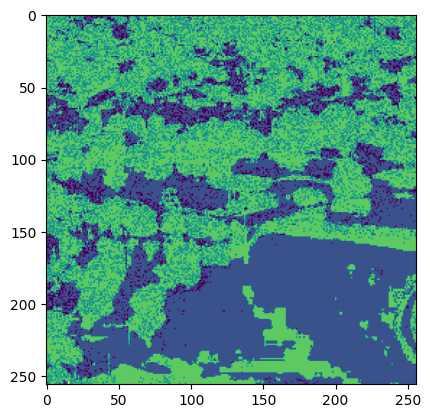

In [24]:
segmented_image = labels.reshape(X_image.shape[:2])
plt.imshow(segmented_image)
plt.show()